上节我们介绍了框架下的注意力机制的主要成分 图10.1.3： 查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚， 注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。 在本节中，我们将介绍注意力汇聚的更多细节， 以便从宏观上了解注意力机制在实践中的运作方式。 具体来说，1964年提出的Nadaraya-Watson核回归模型 是一个简单但完整的例子，可以用于演示具有注意力机制的机器学习。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 10.2.1. 生成数据集
简单起见，考虑下面这个回归问题：
给定的成对的“输入-输出”数据集
$\{ (x_1, y_1),...,(x_n, y_n)  \}$
如何学习 $f$ 来预测任意新输入 x 的输出 $\^y=f(x)$ ？

根据下面的非线性函数生成一个人工数据集， 其中加入的噪声项为 ϵ ：
$$y_i = 2 sin(x_i) + x_i^{0.8} + ϵ$$其中 ϵ 服从均值为 0 和标准差为 0.5 的正态分布。 我们生成了 50 个训练样本和 50 个测试样本。 为了更好地可视化之后的注意力模式，我们将训练样本进行排序。

In [2]:
n_train = 50 # 训练样本数
x_train, _ = torch.sort(
    torch.rand(n_train) * 5
) #  排序后的训练样本
def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0,5,0.1)# 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test)
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数 f （标记为“Truth”）， 以及学习得到的预测函数（标记为“Pred”）。

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(
        x_test,
        [y_truth, y_hat],
        'x','y',
        legend=['Truth', 'Pred'],
        xlim=[0,5],ylim=[-1,5]
    )
    d2l.plt.plot(x_train,y_train,'o',alpha=0.5)

### 10.2.2. 平均汇聚
![平均汇聚](imgs/10_2_2平均汇聚1.png)

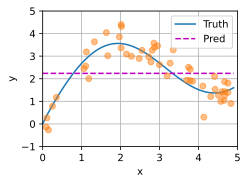

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

repeat_interleave:复制函数

### 10.2.3. 非参数注意力汇聚
显然，平均汇聚忽略了输入 $x_i$!
![](imgs/10_2_3非参数注意力汇聚1.png)

![非参数注意力汇聚](imgs/10_2_3非参数注意力汇聚2.png)

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。 因此， (10.2.6)是 非参数的注意力汇聚（nonparametric attention pooling）模型。 接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。 你会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。

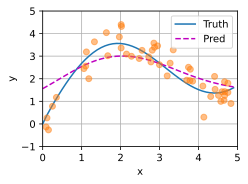

In [5]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在，我们来观察注意力的权重。 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高。

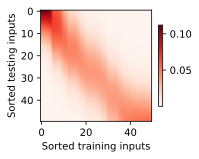

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### 10.2.4. 带参数注意力汇聚
非参数的Nadaraya-Watson核回归具有一致性（consistency）的优点： 如果有足够的数据，此模型会收敛到最优结果。 尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

![带参数注意力汇聚](imgs/10_2_4带参数注意力汇聚1.png)

#### 10.2.4.1. 批量矩阵乘法
为了更有效地计算小批量数据的注意力， 我们可以利用深度学习开发框架中提供的批量矩阵乘法。

假设第一个小批量数据包含 n 个矩阵$ X_1,…,X_n$ ， 形状为 $a×b$ ，
第二个小批量包含 n 个矩阵 $Y_1,…,Y_n$ ， 形状为 $b×c$ 。
它们的批量矩阵乘法得到 n 个矩阵  $X_1Y_1,…,X_nY_n$ ， 形状为 $a×c$ 。
因此，假定两个张量的形状分别是 $(n,a,b)$ 和 $(n,b,c)$ ， 它们的批量矩阵乘法输出的形状为 $(n,a,c)$ 。


In [9]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值。

In [18]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

#### 10.2.4.2. 定义模型


In [19]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

#### 10.2.4.3. 训练
接下来，将训练数据集变换为键和值用于训练注意力模型。 在带参数的注意力汇聚模型中， 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算， 从而得到其对应的预测输出。

In [20]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

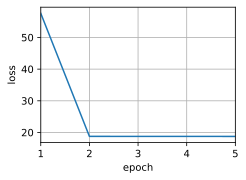

In [21]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

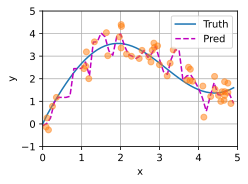

In [22]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

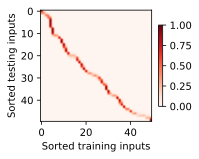

In [23]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')